<h2>Pytorch小试牛刀：CIFAR-10分类</h2>
下面我们来尝试实现对CIFAR-10数据集的分类，步骤如下:

1. 使用torchvision加载并预处理CIFAR-10数据集
2. 定义网络
3. 定义损失函数和优化器
4. 训练网络并更新网络参数
5. 测试网络

### **CIFAR-10数据加载及预处理**
CIFAR-101是一个常用的彩色图片数据集，它有10个类别: 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'。每张图片都是33232，也即3-通道彩色图片，分辨率32*32。

In [1]:
import torchvision as tv
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage
import torch as t

show = ToPILImage()  # 可以把Tensor转成Image，方便可视化
# 第一次运行程序torchvision会自动下载CIFAR-10数据集，
# 大约100M，需花费一定的时间，
# 如果已经下载有CIFAR-10，可通过root参数指定

# 定义对数据的预处理
transform = transforms.Compose([
        transforms.ToTensor(), # 转为Tensor
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # 归一化
                             ])

# 训练集
trainset = tv.datasets.CIFAR10(
                    root='D:\\dtset',
                    train=True,
                    download=True,
                    transform=transform)

trainloader = t.utils.data.DataLoader(
                    trainset,
                    batch_size=4,
                    shuffle=True,
                    num_workers=2)

# 测试集
testset = tv.datasets.CIFAR10(
                    'D:\\dtset',
                    train=False,
                    download=True,
                    transform=transform)

testloader = t.utils.data.DataLoader(
                    testset,
                    batch_size=4,
                    shuffle=False,
                    num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|███████████████████████████████████████████████████████████████| 170498071/170498071 [00:20<00:00, 8206401.63it/s]


Extracting D:\dtset\cifar-10-python.tar.gz to D:\dtset
Files already downloaded and verified


下载地址： https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

Dataset对象是一个数据集，可以按下标访问，返回形如(data, label)的数据。

ship


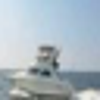

In [2]:
(data, label) = trainset[100]
print(classes[label])

# (data + 1) / 2是为了还原被归一化的数据
show((data + 1) / 2).resize((100, 100))

Dataloader是一个可迭代的对象，它将dataset返回的每一条数据拼接成一个batch，并提供多线程加速优化和数据打乱等操作。当程序对dataset的所有数据遍历完一遍之后，相应的对Dataloader也完成了一次迭代。

      truck        bird         dog        frog


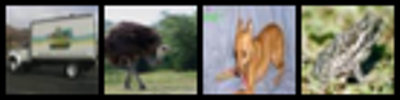

In [4]:
dataiter = iter(trainloader)
images, labels = next(dataiter) # 返回4张图片及标签
print(' '.join('%11s'%classes[labels[j]] for j in range(4)))
show(tv.utils.make_grid((images+1)/2)).resize((400,100))

### **定义网络**
拷贝上面的LeNet网络，修改self.conv1第一个参数为3通道，因CIFAR-10是3通道彩图。

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) 
        self.conv2 = nn.Conv2d(6, 16, 5)  
        self.fc1   = nn.Linear(16*5*5, 120)  
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x): 
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2)) 
        x = F.max_pool2d(F.relu(self.conv2(x)), 2) 
        x = x.view(x.size()[0], -1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)        
        return x


net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


### **定义损失函数和优化器(loss和optimizer)**

In [6]:
from torch import optim
criterion = nn.CrossEntropyLoss() # 交叉熵损失函数
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### **训练网络**
所有网络的训练流程都是类似的，不断地执行如下流程：

+ 输入数据
+ 前向传播+反向传播
+ 更新参数

In [7]:
t.set_num_threads(8)
for epoch in range(2):  
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        
        # 输入数据
        inputs, labels = data
        
        # 梯度清零
        optimizer.zero_grad()
        
        # forward + backward 
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()   
        
        # 更新参数 
        optimizer.step()
        
        # 打印log信息
        # loss 是一个scalar,需要使用loss.item()来获取数值，不能使用loss[0]
        running_loss += loss.item()
        if i % 2000 == 1999: # 每2000个batch打印一下训练状态
            print('[%d, %5d] loss: %.3f' \
                  % (epoch+1, i+1, running_loss / 2000))
            running_loss = 0.0
print('Finished Training')

[1,  2000] loss: 2.243
[1,  4000] loss: 1.898
[1,  6000] loss: 1.663
[1,  8000] loss: 1.588
[1, 10000] loss: 1.511
[1, 12000] loss: 1.462
[2,  2000] loss: 1.401
[2,  4000] loss: 1.362
[2,  6000] loss: 1.325
[2,  8000] loss: 1.304
[2, 10000] loss: 1.291
[2, 12000] loss: 1.248
Finished Training


此处仅训练了2个epoch（遍历完一遍数据集称为一个epoch），来看看网络有没有效果。将测试图片输入到网络中，计算它的label，然后与实际的label进行比较。

实际的label:       cat     ship     ship    plane


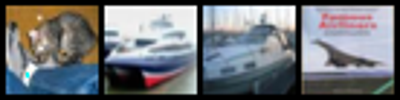

In [9]:
dataiter = iter(testloader)
images, labels = next(dataiter) # 一个batch返回4张图片
print('实际的label: ', ' '.join(\
            '%08s'%classes[labels[j]] for j in range(4)))
show(tv.utils.make_grid(images / 2 - 0.5)).resize((400,100))

接着计算网络预测的label：

In [10]:
# 计算图片在每个类别上的分数
outputs = net(images)
# 得分最高的那个类
_, predicted = t.max(outputs.data, 1)

print('预测结果: ', ' '.join('%5s'\
            % classes[predicted[j]] for j in range(4)))

预测结果:    cat   car truck  ship


已经可以看出效果，准确率100%，但这只是一部分的图片，再来看看在整个测试集上的效果。

In [12]:
correct = 0 # 预测正确的图片数
total = 0 # 总共的图片数


# 由于测试的时候不需要求导，可以暂时关闭autograd，提高速度，节约内存
with t.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = t.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

print('10000张测试集中的准确率为: %d %%' % (100 * correct // total))

10000张测试集中的准确率为: 57 %


10000张测试集中的准确率为: 57 %
训练的准确率远比随机猜测(准确率10%)好，证明网络确实学到了东西。

### **在GPU上训练**
就像之前把Tensor从CPU转到GPU一样，模型也可以类似地从CPU转到GPU。

In [13]:
device = t.device("cuda:0" if t.cuda.is_available() else "cpu")

net.to(device)
images = images.to(device)
labels = labels.to(device)
output = net(images)
loss= criterion(output,labels)

loss

tensor(1.8011, grad_fn=<NllLossBackward0>)